In [1]:
#Run this cell if you are using Google Colab
!git clone https://github.com/nageshsinghc4/deepwrap.git
!cd deepwrap/
import os
os.chdir('/content/deepwrap/')
os.getcwd()
!pip install .

Cloning into 'deepwrap'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 277 (delta 39), reused 256 (delta 27), pack-reused 0
Receiving objects: 100% (277/277), 25.31 MiB | 9.36 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Processing /content/deepwrap
     |████████████████████████████████| 25.9MB 105kB/s 
     |████████████████████████████████| 983kB 35.1MB/s 
     |████████████████████████████████| 245kB 43.0MB/s 
     |████████████████████████████████| 1.1MB 39.6MB/s 
     |████████████████████████████████| 471kB 41.7MB/s 
     |████████████████████████████████| 3.0MB 38.4MB/s 
     |████████████████████████████████| 1.1MB 40.8MB/s 
     |████████████████████████████████| 890kB 44.1MB/s 
  Created wheel for DEEPWRAP: filename=DEEPWRAP-50.3.0-cp36-none-any.whl size=159940 sha256=34762241b2e90113eb05b268626c1fb336f48856232457365bb82564e9edf788
  Stored in directory: /tmp/pi

In [2]:
import deepwrap
from deepwrap import vision
import tensorflow.keras.backend as K

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [3]:
# load cifar10 and manually standaridize
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_test1 = y_test
x_train = x_train.astype('float32')
x_train = (x_train - x_train.mean(axis=0)) / (x_train.std(axis=0))
x_test = x_test.astype('float32')
x_test = (x_test - x_test.mean(axis=0)) / (x_test.std(axis=0))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



170500096/170498071 [==============================] - 11s 0us/step


In [4]:
x_train[0].shape

(32, 32, 3)

In [5]:
input_shape = (32, 32, 3)

In [6]:

# define data augmentation turn featurewise* off, since we've manually standardized above
data_aug = vision.get_data_aug(featurewise_center=False, 
                               featurewise_std_normalization=False,
                               horizontal_flip=True,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.0,
                               rotation_range=10)

classes =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [7]:

# load training and validation data as generators with data augmentation
(train_data, val_data, preproc) = vision.images_from_array(x_train, y_train, 
                                                  validation_data=(x_test, y_test),
                                                  data_aug=data_aug,
                                                  class_names = classes)

In [8]:
# let's examine the available image classifiers
vision.print_image_classifiers()


pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized)
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized)
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized)
wrn22: 22-layer Wide Residual Network (randomly initialized)
default_cnn: a default LeNet-like Convolutional Neural Network


In [9]:
# load a 22-layer Wide ResNet
model = vision.image_classifier('wrn22', train_data, val_data)

Is Multi-Label? False
Is Regression? False
wrn22 model created.


In [11]:
# get a Learner object to be used in training
learner = deepwrap.get_learner(model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=True, batch_size=64)

In [3]:
# find a good learning rate
learner.lr_find()

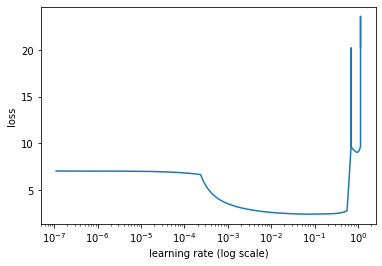

In [13]:
#plot the learning rate
learner.lr_plot()

In [4]:
# fit using onecycle policy
learner.fit_onecycle(1e-3, 30)

In [5]:
learner.validate(class_names=preproc.get_classes())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


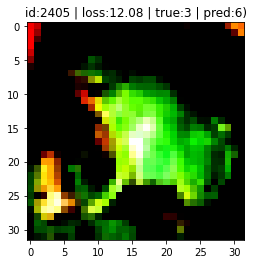

In [ ]:
learner.view_top_losses(n=1)

In [ ]:
loss, acc = learner.model.evaluate_generator(learner.val_data, 
                                             steps=len(learner.val_data))
print('final loss:%s,\n final accuracy:%s' % (loss, acc))

final loss:0.4881359934806824,
 final accuracy:0.9039000272750854


In [ ]:
predictor = deepwrap.get_predictor(learner.model, preproc)

In [ ]:
predictor.predict(x_test[0:1])[0]

'cat'

In [ ]:
import numpy as np
np.argmax(predictor.predict(x_test[0:1], return_proba=True)[0])

3

In [ ]:
predictor.save('/tmp/cifar10')
p = deepwrap.load_predictor('/tmp/cifar10')


In [ ]:
predictions = p.predict(x_test)

In [ ]:
import pandas as pd
df = pd.DataFrame(zip(predictions, y_test1), columns=['Predicted', 'Actual'])
df.head(10)

,Predicted,Actual
0,cat,[3]
1,ship,[8]
2,ship,[8]
3,airplane,[0]
4,frog,[6]
5,frog,[6]
6,automobile,[1]
7,frog,[6]
8,cat,[3]
9,automobile,[1]


In [ ]:
predictor.get_classes()

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Now compare the classes of each label.